In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from pathlib import Path
import argparse
import math
import re
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc, confusion_matrix
from tqdm.notebook import tqdm

sys.path.insert(0, '..')

from util.xai import gradcam, interpolate_expl_matrix, plot_matrix
from models.nt_classifier import build as build_model
from config import *
from util.plot_utils import obtain_plot, plot_logs, plot_roc_curves, collect_results_based_on_confidence_level, various_metrics
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

/data01/giorgio/ENTER/envs/rnarna/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /data01/giorgio/ENTER/envs/rnarna/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops10select_int4callERKNS_6TensorEll
  warn(f"Failed to load image Python extension: {e}")


In [3]:
intarna = pd.read_csv(os.path.join(intarna_dir, 'val500', 'val.csv'), sep = ';')
intarna['key'] = intarna.id1 + '_' + intarna.id2

# keep only the lower E_norm for each group
intarna.sort_values('E_norm', ascending = False, inplace=True)
intarna.drop_duplicates(subset='key', keep='first', inplace=True)
intarna = intarna.reset_index(drop = True)
intarna['couples'] = intarna.id1.str.extractall('(.*)_(.*)').reset_index(drop = True)[0]
intarna['couples'] = intarna['couples'].astype(int)

In [13]:
checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints')

models_to_compare = {}
for file in os.listdir(checkpoint_dir):
    if file.startswith('binary_cl2'):
        if file.endswith('binary_cl2'):
            nickname = 'current'
        else:
            nickname = re.search('(binary_cl2)_(.*)', file).group(2)
        nickname = 'model_' + nickname
        try:
            res = pd.read_csv(os.path.join(checkpoint_dir, file, 'val_results500.csv'))
            res = res.merge(intarna[['E','E_norm', 'couples']].rename({'couples':'id_sample'}, axis =1), on = 'id_sample')
            models_to_compare[nickname] = {'original_name': file, 'df': res}
        except:
            pass

In [5]:
file_train = os.path.join(rna_rna_files_dir, "gene_pairs_training_nt.txt")
with open(file_train, "rb") as fp:   # Unpickling
    gene_pairs_train = pickle.load(fp)
    
file_test = os.path.join(rna_rna_files_dir, "gene_pairs_val_nt.txt")
with open(file_test, "rb") as fp:   # Unpickling
    gene_pairs_test = pickle.load(fp)
    
file_test_subset = os.path.join(rna_rna_files_dir, "gene_pairs_val_sampled_nt.txt")
with open(file_test_subset, "rb") as fp:   # Unpickling
    gene_pairs_test_subset = pickle.load(fp)

In [6]:
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
regex = df_nt[df_nt.couples.isin(gene_pairs_train)].couples_id.str.extractall('(.*)_(.*)').reset_index()
df_train = regex
df_train['g1'] = regex[0]
df_train['g2'] = regex[1]
df_train_genes = set(df_train['g1']).union(set(df_train['g2']))

In [7]:
test500 = pd.read_csv(os.path.join(metadata_dir, 'val500.csv'))

In [8]:
assert test500.couples.isin(gene_pairs_test).all()

# PLOTS

## Metrics

In [9]:
N_iters = 25

In [10]:
def balance_df(df):
    negs = df[df.ground_truth == 0]
    poss = df[df.ground_truth == 1]
    
    n_to_sample = min(poss.shape[0], negs.shape[0])

    if poss.shape[0] > negs.shape[0]:
        return pd.concat([poss.sample(n_to_sample), negs], axis = 0).reset_index(drop = True)
    else:
        return pd.concat([negs.sample(n_to_sample), poss], axis = 0).reset_index(drop = True)

In [11]:
results = {}
set_collected = []

In [14]:
key_name = 'full_data'
results[key_name] = {}
set_collected.append(key_name)
for model in tqdm(models_to_compare.keys()):
    res = models_to_compare[model]['df']
    tot = res.shape[0]
    perc = np.round(res.shape[0]/tot * 100, 2)
    res_list = []
    for i in range(N_iters):
        res_balanced = balance_df(res)
        res_list.append(res_balanced)
    res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
    acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
    fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
    roc = auc(fpr, tpr)
    fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
    roc_intarna =  auc(fpr, tpr)
    dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                   'f2':f2, 'specificity':specificity, 'npv':npv, 
                   'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
    results[key_name][model] = dict_result

  0%|          | 0/8 [00:00<?, ?it/s]

In [15]:
key_name = 'easypos_easyneg_hardneg'
results[key_name] = {}
set_collected.append(key_name)
for model in tqdm(models_to_compare.keys()):
    res = models_to_compare[model]['df']
    tot = res.shape[0]
    res = res[res.policy.isin(['easypos', 'easyneg', 'hardneg'])]
    perc = np.round(res.shape[0]/tot * 100, 2)
    res_list = []
    for i in range(N_iters):
        res_balanced = balance_df(res)
        res_list.append(res_balanced)
    res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
    acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
    fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
    roc = auc(fpr, tpr)
    fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
    roc_intarna =  auc(fpr, tpr)
    dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                   'f2':f2, 'specificity':specificity, 'npv':npv, 
                   'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
    results[key_name][model] = dict_result

  0%|          | 0/8 [00:00<?, ?it/s]

In [16]:
key_name = 'easypos_easyneg_hardneg_not_in_train'
set_collected.append(key_name)
results[key_name] = {}
for model in tqdm(models_to_compare.keys()):
    res = models_to_compare[model]['df']
    tot = res.shape[0]
    res = res[res.policy.isin(['easypos', 'easyneg', 'hardneg'])]
    res = res[~(res.gene1_original.isin(df_train_genes) | res.gene2_original.isin(df_train_genes))]
    perc = np.round(res.shape[0]/tot * 100, 2)
    res_list = []
    for i in range(N_iters):
        res_balanced = balance_df(res)
        res_list.append(res_balanced)
    res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
    acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
    fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
    roc = auc(fpr, tpr)
    fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
    roc_intarna =  auc(fpr, tpr)
    dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                   'f2':f2, 'specificity':specificity, 'npv':npv, 
                   'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
    results[key_name][model] = dict_result

  0%|          | 0/8 [00:00<?, ?it/s]

In [17]:
key_name = 'easypos_smartneg'
set_collected.append(key_name)
results[key_name] = {}
for model in tqdm(models_to_compare.keys()):
    res = models_to_compare[model]['df']
    tot = res.shape[0]
    res = res[res.policy.isin(['easypos', 'smartneg'])]
    perc = np.round(res.shape[0]/tot * 100, 2)
    res_list = []
    for i in range(N_iters):
        res_balanced = balance_df(res)
        res_list.append(res_balanced)
    res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
    acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
    fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
    roc = auc(fpr, tpr)
    fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
    roc_intarna =  auc(fpr, tpr)
    dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                   'f2':f2, 'specificity':specificity, 'npv':npv, 
                   'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
    results[key_name][model] = dict_result

  0%|          | 0/8 [00:00<?, ?it/s]

In [18]:
key_name = 'easypos_smartneg_not_in_train'
set_collected.append(key_name)
results[key_name] = {}
for model in tqdm(models_to_compare.keys()):
    res = models_to_compare[model]['df']
    tot = res.shape[0]
    res = res[res.policy.isin(['easypos', 'smartneg'])]
    res = res[~(res.gene1_original.isin(df_train_genes) | res.gene2_original.isin(df_train_genes))]
    perc = np.round(res.shape[0]/tot * 100, 2)
    res_list = []
    for i in range(N_iters):
        res_balanced = balance_df(res)
        res_list.append(res_balanced)
    res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
    acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
    fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
    roc = auc(fpr, tpr)
    fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
    roc_intarna =  auc(fpr, tpr)
    dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                   'f2':f2, 'specificity':specificity, 'npv':npv, 
                   'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
    results[key_name][model] = dict_result

  0%|          | 0/8 [00:00<?, ?it/s]

In [19]:
key_name = 'easypos_smartneg_not_in_train_55_conf'
set_collected.append(key_name)
results[key_name] = {}
for model in tqdm(models_to_compare.keys()):
    res = models_to_compare[model]['df']
    tot = res.shape[0]
    res = res[res.policy.isin(['easypos', 'smartneg'])]
    res = res[~(res.gene1_original.isin(df_train_genes) | res.gene2_original.isin(df_train_genes))]
    res = res[(res.probability>0.55)|(res.probability<(1-0.55))]
    perc = np.round(res.shape[0]/tot * 100, 2)
    res_list = []
    for i in range(N_iters):
        res_balanced = balance_df(res)
        res_list.append(res_balanced)
    res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
    acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
    fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
    roc = auc(fpr, tpr)
    fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
    roc_intarna =  auc(fpr, tpr)
    dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                   'f2':f2, 'specificity':specificity, 'npv':npv, 
                   'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
    results[key_name][model] = dict_result

  0%|          | 0/8 [00:00<?, ?it/s]

In [20]:
key_name = 'easypos_smartneg_not_in_train_65_conf'
set_collected.append(key_name)
results[key_name] = {}
for model in tqdm(models_to_compare.keys()):
    res = models_to_compare[model]['df']
    tot = res.shape[0]
    res = res[res.policy.isin(['easypos', 'smartneg'])]
    res = res[~(res.gene1_original.isin(df_train_genes) | res.gene2_original.isin(df_train_genes))]
    res = res[(res.probability>0.65)|(res.probability<(1-0.65))]
    perc = np.round(res.shape[0]/tot * 100, 2)
    res_list = []
    for i in range(N_iters):
        res_balanced = balance_df(res)
        res_list.append(res_balanced)
    res_balanced = pd.concat(res_list, axis = 0).reset_index(drop = True)
    acc, prec, recall, f2, specificity, npv = various_metrics(res_balanced)
    fpr, tpr, _ = roc_curve(res_balanced.ground_truth, res_balanced.probability)
    roc = auc(fpr, tpr)
    fpr, tpr, _ = roc_curve(abs(1 - res_balanced.ground_truth), res_balanced.E_norm)
    roc_intarna =  auc(fpr, tpr)
    dict_result = {'acc':acc, 'prec':prec, 'recall':recall, 
                   'f2':f2, 'specificity':specificity, 'npv':npv, 
                   'roc': roc, 'roc_intarna':roc_intarna, 'perc_data':perc}
    results[key_name][model] = dict_result

  0%|          | 0/8 [00:00<?, ?it/s]

In [21]:
metric_to_print = 'acc'
for current_set in set_collected:
    print('--- ', current_set, ' --- ')
    for model in models_to_compare.keys():
        metric = np.round(results[current_set][model][metric_to_print], 3)
        print(model + f' {metric_to_print}:', metric)
    print('\n')

---  full_data  --- 
model_1 acc: 0.575
model_2 acc: 0.57
model_4 acc: 0.553
model_5 acc: 0.553
model_old acc: 0.575
model_6 acc: 0.555
model_3 acc: 0.562
model_current acc: 0.574


---  full_data  --- 
model_1 acc: 0.575
model_2 acc: 0.57
model_4 acc: 0.553
model_5 acc: 0.553
model_old acc: 0.575
model_6 acc: 0.555
model_3 acc: 0.562
model_current acc: 0.574


---  easypos_easyneg_hardneg  --- 
model_1 acc: 0.672
model_2 acc: 0.662
model_4 acc: 0.632
model_5 acc: 0.64
model_old acc: 0.647
model_6 acc: 0.637
model_3 acc: 0.641
model_current acc: 0.666


---  easypos_easyneg_hardneg_not_in_train  --- 
model_1 acc: 0.647
model_2 acc: 0.71
model_4 acc: 0.57
model_5 acc: 0.58
model_old acc: 0.602
model_6 acc: 0.612
model_3 acc: 0.587
model_current acc: 0.552


---  easypos_smartneg  --- 
model_1 acc: 0.568
model_2 acc: 0.563
model_4 acc: 0.547
model_5 acc: 0.546
model_old acc: 0.57
model_6 acc: 0.549
model_3 acc: 0.556
model_current acc: 0.567


---  easypos_smartneg_not_in_train  --- 
mod

In [22]:
metric_to_print = 'roc'
for current_set in set_collected:
    print('--- ', current_set, ' --- ')
    for model in models_to_compare.keys():
        metric = np.round(results[current_set][model][metric_to_print], 3)
        print(model + f' {metric_to_print}:', metric)
    print('\n')

---  full_data  --- 
model_1 roc: 0.61
model_2 roc: 0.603
model_4 roc: 0.581
model_5 roc: 0.578
model_old roc: 0.613
model_6 roc: 0.584
model_3 roc: 0.593
model_current roc: 0.611


---  full_data  --- 
model_1 roc: 0.61
model_2 roc: 0.603
model_4 roc: 0.581
model_5 roc: 0.578
model_old roc: 0.613
model_6 roc: 0.584
model_3 roc: 0.593
model_current roc: 0.611


---  easypos_easyneg_hardneg  --- 
model_1 roc: 0.745
model_2 roc: 0.754
model_4 roc: 0.719
model_5 roc: 0.727
model_old roc: 0.705
model_6 roc: 0.722
model_3 roc: 0.701
model_current roc: 0.735


---  easypos_easyneg_hardneg_not_in_train  --- 
model_1 roc: 0.713
model_2 roc: 0.781
model_4 roc: 0.819
model_5 roc: 0.841
model_old roc: 0.673
model_6 roc: 0.808
model_3 roc: 0.699
model_current roc: 0.613


---  easypos_smartneg  --- 
model_1 roc: 0.6
model_2 roc: 0.591
model_4 roc: 0.571
model_5 roc: 0.567
model_old roc: 0.605
model_6 roc: 0.574
model_3 roc: 0.585
model_current roc: 0.601


---  easypos_smartneg_not_in_train  --- 


In [23]:
metric_to_print = 'perc_data'
for current_set in set_collected:
    print('--- ', current_set, ' --- ')
    for model in models_to_compare.keys():
        metric = np.round(results[current_set][model][metric_to_print], 3)
        print(model + f' {metric_to_print}:', metric)
    print('\n')

---  full_data  --- 
model_1 perc_data: 100.0
model_2 perc_data: 100.0
model_4 perc_data: 100.0
model_5 perc_data: 100.0
model_old perc_data: 100.0
model_6 perc_data: 100.0
model_3 perc_data: 100.0
model_current perc_data: 100.0


---  full_data  --- 
model_1 perc_data: 100.0
model_2 perc_data: 100.0
model_4 perc_data: 100.0
model_5 perc_data: 100.0
model_old perc_data: 100.0
model_6 perc_data: 100.0
model_3 perc_data: 100.0
model_current perc_data: 100.0


---  easypos_easyneg_hardneg  --- 
model_1 perc_data: 36.65
model_2 perc_data: 36.65
model_4 perc_data: 36.65
model_5 perc_data: 36.65
model_old perc_data: 36.65
model_6 perc_data: 36.65
model_3 perc_data: 36.65
model_current perc_data: 36.65


---  easypos_easyneg_hardneg_not_in_train  --- 
model_1 perc_data: 0.35
model_2 perc_data: 0.35
model_4 perc_data: 0.35
model_5 perc_data: 0.35
model_old perc_data: 0.35
model_6 perc_data: 0.35
model_3 perc_data: 0.35
model_current perc_data: 0.35


---  easypos_smartneg  --- 
model_1 perc_da

In [39]:
best_models = ['model_1', 'model_3', 'model_old']
metric_to_print = ['acc', 'roc', 'roc_intarna', 'perc_data']
set_to_print = ['easypos_easyneg_hardneg_not_in_train', 'easypos_smartneg', 'easypos_smartneg_not_in_train', 'easypos_smartneg_not_in_train_65_conf']

In [30]:
metric_to_print = 'roc'

for model in best_models:
    original_name = models_to_compare[model]['original_name']
    for current_set in set_to_print:
        for metric in metric_to_print:
            results[current_set][metric]

In [ ]:
#anni -> metrica(roc, acc_easypos_smartneg, acc_hardneg_easypos, ...)
#(it, ece, cse) -> (model1, model2, model3)

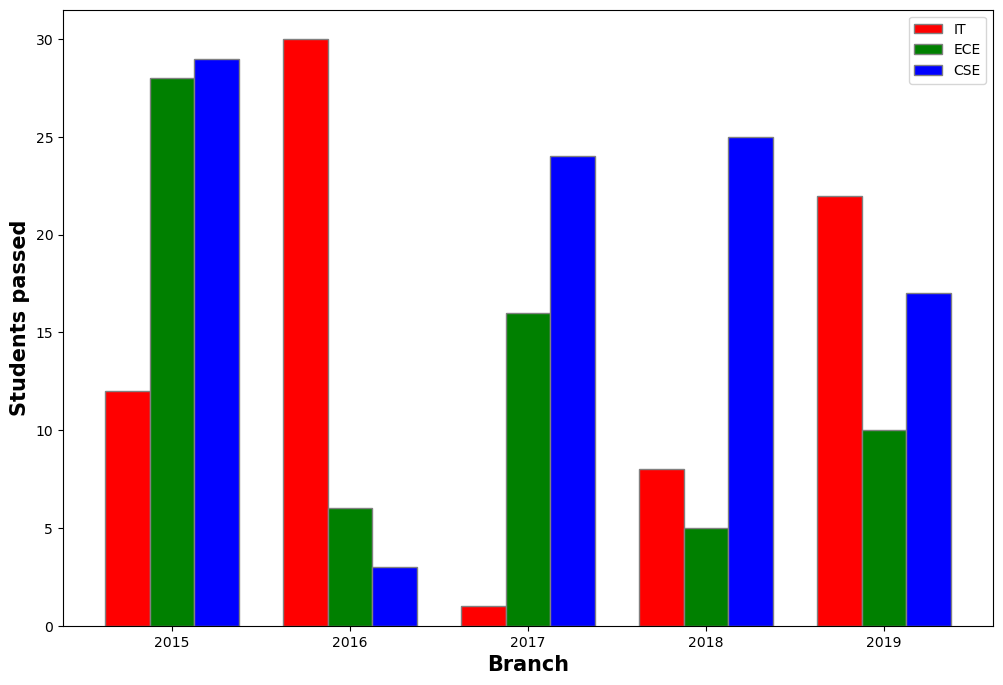

In [33]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
IT = [12, 30, 1, 8, 22]
ECE = [28, 6, 16, 5, 10]
CSE = [29, 3, 24, 25, 17]
 
# Set position of bar on X axis
br1 = np.arange(len(IT))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, IT, color ='r', width = barWidth,
        edgecolor ='grey', label ='IT')
plt.bar(br2, ECE, color ='g', width = barWidth,
        edgecolor ='grey', label ='ECE')
plt.bar(br3, CSE, color ='b', width = barWidth,
        edgecolor ='grey', label ='CSE')
 
# Adding Xticks
plt.xlabel('Branch', fontweight ='bold', fontsize = 15)
plt.ylabel('Students passed', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(IT))],
        ['2015', '2016', '2017', '2018', '2019'])
 
plt.legend()
plt.show()

In [22]:
best_model_chosen = 'model_1'


# Define the path to the file containing the args namespace
args_path = os.path.join(ROOT_DIR, 'checkpoints', models_to_compare[best_model_chosen]['original_name'], 'args.pkl')

# Load the args namespace from the file
with open(args_path, 'rb') as f:
    args_dict = pickle.load(f)
    
print(args_dict)
print(args_dict['policies_train'][0].height_bins)
print(args_dict['policies_train'][0].height_probabilities)

{'lr': 0.0001, 'lr_backbone': 0.0001, 'batch_size': 32, 'weight_decay': 0.0001, 'epochs': 100, 'lr_drop': 200, 'clip_max_norm': 0.1, 'proj_module_N_channels': 0, 'proj_module_secondary_structure_N_channels': 4, 'drop_secondary_structure': False, 'use_projection_module': False, 'dropout_prob': 0.01, 'args.mini_batch_size': 32, 'num_hidden_layers': 1, 'dividing_factor': 20, 'output_channels_mlp': 256, 'n_channels1_cnn': 256, 'n_channels2_cnn': 512, 'min_n_groups_train': 5, 'max_n_groups_train': 80, 'min_n_groups_val': 80, 'max_n_groups_val': 80, 'policies_train': [<dataset.data.EasyPosAugment object at 0x7fc5eb8d2680>, <dataset.data.SmartNegAugment object at 0x7fc5eb8d3b80>], 'policies_val': [<dataset.data.EasyPosAugment object at 0x7fc5eb8d2200>, <dataset.data.SmartNegAugment object at 0x7fc5eb8d24a0>], 'dataset_path': '/data01/giorgio/RNARNA-NT/dataset', 'device': 'cuda', 'seed': 42, 'num_workers': 2, 'output_dir': '/data01/giorgio/RNARNA-NT/checkpoints/binary_cl2', 'resume': '', 'star